In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel
from gensim.models.phrases import Phraser
from gensim.matutils import corpus2csc
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel, Phrases
import re
import spacy
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from MulticoreTSNE import MulticoreTSNE as TSNE
import pyLDAvis
import pyLDAvis.gensim
import warnings
from tqdm import tqdm
from collections import Counter

np.random.seed(23)

def load_data():
    data_path = Path('./data')
    print('loading ./data/html_and_text_big.csv into dataframe')
    df = pd.read_csv(data_path/'html_and_text_big.csv',index_col=0)
    print('done')
    return df

def elbow_plot(dictionary, corpus, texts, limit, score_type):
    scores = []
    models = []
    for num_topics in tqdm(range(1, limit+1)):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        models.append(lda)
        if score_type=='coherence':
            score = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
        if score_type=='perplexity':
            score = np.exp(lda.log_perplexity(corpus))
        scores.append(score)
    return models,scores

In [49]:
df = load_data()
df = df[df.is_justext==1]
df['relevant'] = df.text.apply(lambda x: 'parkland' in x.lower() or 'marjory stoneman douglas' in x.lower())
df = df[df.relevant]
df.shape

(6210, 7)

In [51]:
r = np.random.randint(0,len(df)-1,10)
for s in df.text.iloc[r].values:
    print(s)
    print()

Lt. Gov. Casey Cagle and Gov. Deal's chief of staff Chris Riley confer in the senate before the senate went into recess and the Rules Committee stripped the Delta tax cut from legislation. Gov. Nathan Deal and legislative leaders had hoped they could make a deal Wednesday, Feb. 28, 2018, on the Delta fuel tax legislation - which also includes a state income tax rate cut.(Bob Andres/Atlanta Journal-Constitution via AP) Senator Steve Henson, D - Stone Mountain, speaks Thursday, March 1, 2018, in Atlanta, in opposition to HB 918. He said that while he supported portions of the bill, he thought the state should look to funding programs such as education. The Georgia Senate passed legislation to lower the state income tax rate now that the bill no longer includes a tax break for Delta. The House may take it up as well, giving it final approval and sending it to Gov. Nathan Deal, who has promised to sign it. Deal cleared the way for it Wednesday, agreeing to sign the measure without the Delt

In [108]:
stop_words = stopwords.words('english') #+ ['said','would','also','us','one','two','since','day','jpghttps','people',
                                        #   'school','students','shooting','marjory','stoneman','douglas','high','florida'
                                        #   'parkland','going','get','many','know','like']
df['text_processed'] = df.text.apply(lambda x: ' '.join(word for word in simple_preprocess(x) if word not in stop_words))
df['text_processed'] = df.text_processed.apply(lambda x:x.encode("ascii", errors="ignore").decode())

nlp = spacy.load('en')#('en_core_web_sm')
df['tokens'] = df.text_processed.apply(lambda x:' '.join(t.text for t in nlp.tokenizer(x)))

In [109]:
texts = [row.split() for row in df.tokens]
bigram = Phrases(texts)
bigram_model = Phraser(bigram)
bigrams = [bigram_model[doc] for doc in texts]

In [110]:
all_tokens = [item for sublist in bigrams for item in sublist]
ctr = Counter(all_tokens)
ctr.most_common(50)
# s = pd.DataFrame(data=[[key,val] for key,val in ctr.items()],columns=['word','freq'])
# s[s.freq<=2].shape

[('school', 55130),
 ('said', 41628),
 ('shooting', 27373),
 ('students', 25649),
 ('people', 15183),
 ('marjory_stoneman', 14682),
 ('douglas_high', 13875),
 ('florida', 13457),
 ('one', 13296),
 ('cruz', 12812),
 ('parkland', 11732),
 ('would', 9076),
 ('high_school', 8923),
 ('also', 8446),
 ('killed', 7126),
 ('student', 6880),
 ('stoneman_douglas', 6591),
 ('broward_county', 6265),
 ('time', 5834),
 ('like', 5816),
 ('day', 5774),
 ('know', 5670),
 ('israel', 5252),
 ('going', 5092),
 ('victims', 4982),
 ('told', 4916),
 ('wednesday', 4884),
 ('first', 4794),
 ('police', 4765),
 ('us', 4747),
 ('get', 4706),
 ('feb', 4672),
 ('gun', 4655),
 ('could', 4637),
 ('two', 4564),
 ('many', 4529),
 ('shooter', 4527),
 ('year_old', 4484),
 ('back', 4264),
 ('nikolas_cruz', 4166),
 ('gun_control', 4164),
 ('says', 4144),
 ('teachers', 4081),
 ('building', 3987),
 ('news', 3904),
 ('schools', 3835),
 ('since', 3751),
 ('peterson', 3721),
 ('want', 3687),
 ('kids', 3645)]

In [113]:
id2word = Dictionary(bigrams)
corpus = [id2word.doc2bow(text) for text in bigrams]

tfidf = TfidfModel(corpus, id2word=id2word)
tfidf_corpus = tfidf[corpus]
# low_value = 1e-5
# low_value_words = []
# for bow in corpus:
#     low_value_words += [id for id, value in tfidf[bow] if value < low_value]
# id2word.filter_tokens(bad_ids=low_value_words)
# new_corpus = [id2word.doc2bow(text) for text in bigrams]
# corpus = new_corpus

In [114]:
num_topics = 2
warnings.filterwarnings('ignore')
#lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
lda = LsiModel(corpus=tfidf_corpus, id2word=id2word, num_topics=10)
lda_corpus = lda[corpus]
for top in lda.print_topics():
    print(top)

(0, '-0.213*"legislative_session" + 0.158*"gun_lobby" + -0.120*"air" + -0.111*"high_school" + 0.110*"ok" + 0.100*"gateway_pundit" + 0.096*"actions" + -0.093*"wounded" + -0.091*"dedicating" + 0.089*"marches"')
(1, '-0.229*"march_washington" + -0.197*"classrooms" + -0.182*"coping" + -0.173*"inspiring" + -0.161*"unlikely_happen" + -0.160*"chanting" + -0.147*"survived_mass" + -0.141*"gets" + -0.137*"actions" + -0.131*"ultimately_left"')
(2, '0.222*"stay" + 0.167*"air" + 0.159*"march_washington" + -0.154*"inspiring" + -0.125*"profanity" + 0.118*"somewhat_responsible" + -0.103*"getting_ready" + -0.103*"shot_wherever" + 0.100*"dedicating" + -0.099*"employees"')
(3, '-0.172*"unlikely_happen" + -0.170*"coherent" + 0.149*"inspiring" + -0.148*"high_school" + 0.146*"air" + 0.131*"gets" + -0.121*"jr" + -0.121*"ok" + 0.119*"classrooms" + 0.114*"korsten_student"')
(4, '-0.265*"inspiring" + 0.177*"assault" + 0.171*"basketball_players" + 0.167*"gets" + -0.128*"trying" + -0.126*"stay" + 0.116*"threatene

In [115]:
# pyLDAvis.enable_notebook()
# warnings.filterwarnings('ignore')
# vis = pyLDAvis.gensim.prepare(lda,corpus,id2word)
# vis

100%|██████████| 30/30 [09:04<00:00, 19.96s/it]


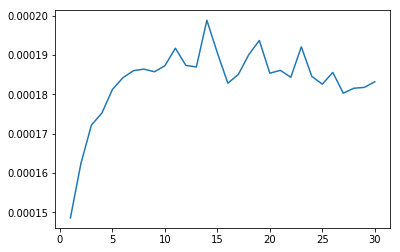

In [117]:
limit = 30
models,scores = elbow_plot(id2word,corpus,bigrams,limit,'perplexity')
plt.plot(range(1,limit+1),scores)

100%|██████████| 30/30 [12:33<00:00, 31.96s/it]


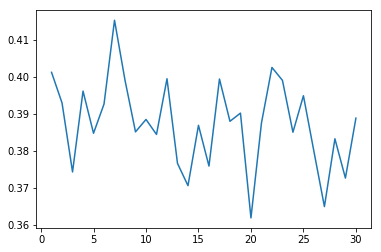

In [118]:
limit = 30
models,scores = elbow_plot(id2word,corpus,bigrams,limit,'coherence')
plt.plot(range(1,limit+1),scores)